In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import glob
from tqdm.notebook import trange, tqdm
import json
import re
import pandas as pd
import numpy as np
from collections import defaultdict

from utills import chunker, cartesian_product, get_num_chunks
from train_utils import generate_unique_pairs, get_random_author_excluding, generate_doc_pairs, fit_transformers, vectorize


from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

In [3]:

from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'
chunk_sz=10
TEMP_DATA = '../temp_data/reddit/multidoc_' + str(chunk_sz) + '/'

In [5]:
with open(COMPUTED_DATA_PATH + 'metadata.p', 'rb') as f:
    (train_files, test_files, min_count, author_mapping) = pickle.load(f)

Vectorize Data
===

In [6]:
transformer, scaler, secondary_scaler = fit_transformers(
    COMPUTED_DATA_PATH + 'train.jsonl', 
    author_mapping, 
    chunk_sz, 
    sample_fraction=0.05
)

Sampled: 5244
Reading preprocessed data...



Fitting transformer
Generating pairs


In [7]:
with open(TEMP_DATA + 'model_' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((transformer, scaler, secondary_scaler ), f)

In [8]:
XX_train, author_bounds, author_subreddit, x_shape = vectorize(
    preprocessed_path = COMPUTED_DATA_PATH + 'train.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_train_' + str(chunk_sz) + '.npy', 
    transformer=transformer,
    scaler=scaler,
    chunk_sz=chunk_sz
)

Precomputing record size...


In [9]:
XX_test, author_bounds_test, author_subreddit_test, x_shape_test = vectorize(
    preprocessed_path = COMPUTED_DATA_PATH + 'test.jsonl', 
    vectorized_x_path = TEMP_DATA + 'XX_test_' + str(chunk_sz) + '.npy', 
    transformer=transformer,
    scaler=scaler,
    chunk_sz=chunk_sz
)

Precomputing record size...


In [10]:
with open(TEMP_DATA + 'experiment_data' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((author_bounds, author_bounds_test, author_subreddit, author_subreddit_test, x_shape, x_shape_test), f)

Train the classifier
===

In [11]:
author_mapping = defaultdict(set)
author_to_root = {}
for y in author_bounds.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping[u].add(y)
    author_to_root[y] = u

subreddit_to_author = defaultdict(list)
for k, v in author_subreddit.items():
    subreddit_to_author[v].append(k)

    
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_bounds_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

subreddit_to_author_test = defaultdict(list)
for k, v in author_subreddit_test.items():
    subreddit_to_author_test[v].append(k)

X_idxs_train, Y_train = generate_doc_pairs(author_mapping, subreddit_to_author, author_to_root, author_bounds, author_subreddit)
X_idxs_test, Y_test = generate_doc_pairs(author_mapping_test, subreddit_to_author_test, author_to_root_test, author_bounds_test, author_subreddit_test)




In [ ]:
len(Y_train), Y_train.mean()

(27709267, 0.5000000180445048)

In [19]:
with open(TEMP_DATA + 'experiment_data' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((
        author_bounds, 
        author_bounds_test, 
        author_subreddit, 
        author_subreddit_test, 
        x_shape, 
        x_shape_test,
        X_idxs_train,
        Y_train,
        X_idxs_test,
        Y_test
    ), f)

In [ ]:
batch_sz = 50000
clf = SGDClassifier(loss='log', alpha=0.01)
x_test_diff_sample = secondary_scaler.transform(np.abs(XX_test[X_idxs_test[:batch_sz, 0]] - XX_test[X_idxs_test[:batch_sz, 1]]))
y_test_sample = Y_test[:batch_sz]
aucs = []
for i in range(100):
    for idxs in chunker(np.arange(len(X_idxs_train)), batch_sz):
        x_diff = secondary_scaler.transform(np.abs(XX_train[X_idxs_train[idxs, 0]] - XX_train[X_idxs_train[idxs, 1]]))
        x_diff[np.isnan(x_diff)]=0
        y = Y_train[idxs]
        clf.partial_fit(x_diff, y, classes=[0, 1])

        probs = clf.predict_proba(x_test_diff_sample)[:, 1]

        fpr, tpr, thresh = roc_curve(y_test_sample, probs)
        roc_auc = auc(fpr, tpr)
        print('AUC:', roc_auc)
    print('~'*20, 'Epoch: ', i)
    aucs.append(roc_auc)

AUC: 0.7408706398060569
AUC: 0.7526127065898439
AUC: 0.7712625936027568
AUC: 0.7863640032598936
AUC: 0.7891394994092484
AUC: 0.7961558089445422
AUC: 0.8037120809990852
AUC: 0.8118774742955441
AUC: 0.8106769118942001
AUC: 0.8131419209949466
AUC: 0.818872618932091
AUC: 0.8194951754366905
AUC: 0.8184919691561312
AUC: 0.8231602565364928
AUC: 0.8243558845148147
AUC: 0.8258009824570637
AUC: 0.8266782009498144
AUC: 0.8248365907575977
AUC: 0.8276198269430646
AUC: 0.8275972532377447
AUC: 0.8306214945476449
AUC: 0.8297283383805356
AUC: 0.8308448715898329
AUC: 0.8303825462328077
AUC: 0.8333970930974777
AUC: 0.8335060152056646
AUC: 0.8326261999007982
AUC: 0.8322735502554761
AUC: 0.8329050780019321
AUC: 0.833045123455328
AUC: 0.8335878651875437
AUC: 0.8355824344934064
AUC: 0.835420390537374
AUC: 0.8346074227443917
AUC: 0.8361173817892564
AUC: 0.8361176993907383
AUC: 0.8340066543414466
AUC: 0.8351513412820979
AUC: 0.8357236415522221
AUC: 0.8356385835553756
AUC: 0.8377100652200803
AUC: 0.836774329654

AUC: 0.8433947557425725
AUC: 0.8435324587850397
AUC: 0.8435124522916975
AUC: 0.8434856569666811
AUC: 0.8437336517237256
AUC: 0.8436459265144347
AUC: 0.843294588875234
AUC: 0.8436840610923555
AUC: 0.8433475603223776
AUC: 0.8435223803380177
AUC: 0.8434640520658813
AUC: 0.8435111754857403
AUC: 0.8437016787745526
AUC: 0.8435449068431174
AUC: 0.8437576646357602
AUC: 0.8437771527266839
AUC: 0.8440315107134164
AUC: 0.8436529233470791
AUC: 0.8436735986435419
AUC: 0.8438833244220385
AUC: 0.8440562852290044
AUC: 0.8440562788289745
AUC: 0.8436437233041554
AUC: 0.844074221312687
AUC: 0.8439717824347481
AUC: 0.843912828559693
AUC: 0.8438213321328071
AUC: 0.8438759339875577
AUC: 0.8436378688768411
AUC: 0.8438313081793515
AUC: 0.843738426146001
AUC: 0.8435697117588472
AUC: 0.8436170783798409
AUC: 0.8436717890350989
AUC: 0.8435320315830466
AUC: 0.8437284516994642
AUC: 0.8436078207366485
AUC: 0.8436962867493955
AUC: 0.8436662754093746
AUC: 0.8434543144204493
AUC: 0.843818599320057
AUC: 0.84397547525197

AUC: 0.8442563069622258
AUC: 0.8444441958388402
AUC: 0.8443584258386716
AUC: 0.8442175691814908
AUC: 0.8443783875318048
AUC: 0.8442265068231902
AUC: 0.8440336019231731
AUC: 0.8443274912943435
AUC: 0.8441274087608382
AUC: 0.8442086763400005
AUC: 0.8442304556416138
AUC: 0.8443143056328244
AUC: 0.8441387896139368
AUC: 0.8442427756990943
AUC: 0.8444918296610805
AUC: 0.8443279760966053
AUC: 0.8445076105347077
AUC: 0.8444593415095039
AUC: 0.8445727452386
AUC: 0.8444896568509431
AUC: 0.8444304181745591
AUC: 0.844533652256208
AUC: 0.844455037489423
AUC: 0.8444691975554882
AUC: 0.844484674427697
AUC: 0.844441095024373
AUC: 0.8446094510098546
AUC: 0.8443354833316309
AUC: 0.8441494520636834
AUC: 0.8441217783345691
AUC: 0.8441646921347876
AUC: 0.8439861137016121
AUC: 0.844207140332834
AUC: 0.8442796174709835
AUC: 0.8441377416090473
AUC: 0.8443399473524584
AUC: 0.8442221532028781
AUC: 0.8441552872909085
AUC: 0.8442377148754825
AUC: 0.8442970015520903
AUC: 0.8442145163672475
AUC: 0.8441086150731545


AUC: 0.8447943654725916
AUC: 0.8448046983208005
AUC: 0.8446385951458295
AUC: 0.844577276459741
AUC: 0.844575366050828
AUC: 0.8446631456603724
AUC: 0.8447069986649729
AUC: 0.8445619115880547
AUC: 0.8446271022922085
AUC: 0.8446805361415095
AUC: 0.8446487151930456
AUC: 0.8445810908775376
AUC: 0.8445497099311267
AUC: 0.8445972013527026
AUC: 0.8445591723752747
AUC: 0.8445860957008882
AUC: 0.8445344762600524
AUC: 0.844758144503599
AUC: 0.8446399855523167
AUC: 0.8444749895825115
AUC: 0.8445680508166981
AUC: 0.844637822342224
AUC: 0.844682956952804
AUC: 0.8445048153216663
AUC: 0.844576756457315
AUC: 0.8445113081519593
AUC: 0.8445001288998014
AUC: 0.8444210501308514
AUC: 0.8445275706278335
AUC: 0.8446311135109231
AUC: 0.8445269226248102
AUC: 0.8445317946475411
AUC: 0.8445884397118243
AUC: 0.8445061337278175
AUC: 0.8445200857929123
AUC: 0.8445155689718387
AUC: 0.8445193289893813
AUC: 0.8445457163124939
AUC: 0.8444458902467455
AUC: 0.8445044025197403
AUC: 0.8444538422838466
AUC: 0.844363427462007

AUC: 0.8444786855997555
AUC: 0.8446227086717095
AUC: 0.8445523083432498
AUC: 0.8444090260747521
AUC: 0.8443764531227796
AUC: 0.8444749271822202
AUC: 0.8445674972141151
AUC: 0.8443945492072088
AUC: 0.8445092601424042
AUC: 0.844645547178265
AUC: 0.8446733569080138
AUC: 0.8446427551652386
AUC: 0.8446795009366797
AUC: 0.8446627952587376
AUC: 0.8446213566654017
AUC: 0.8446600624459873
AUC: 0.8446897649845674
AUC: 0.8447846758273836
AUC: 0.8447539236839064
AUC: 0.8445621739892789
AUC: 0.8446183070511734
AUC: 0.8446399967523689
AUC: 0.8446267470905511
AUC: 0.8446334815219714
AUC: 0.8446491535950911
AUC: 0.8446488335935981
AUC: 0.8447456612453571
AUC: 0.8447961366808553
AUC: 0.8446649952690017
AUC: 0.8446026717782255
AUC: 0.8446775505275796
AUC: 0.844740093219379
AUC: 0.8447376468079649
AUC: 0.8447112450847851
AUC: 0.8446561104275487
AUC: 0.844795210276533
AUC: 0.8448795258699159
AUC: 0.8447826886181119
AUC: 0.8446367503372224
AUC: 0.8447079986696386
AUC: 0.8447527860785988
AUC: 0.844714221098

AUC: 0.8445437659033943
AUC: 0.8444257461527612
AUC: 0.8445056409255184
AUC: 0.8445373466734446
AUC: 0.8444539206842123
AUC: 0.8445898813185504
AUC: 0.8445980573566964
AUC: 0.8446606000484955
AUC: 0.8447044546531037
AUC: 0.8445902509202746
AUC: 0.8446532768143282
AUC: 0.8445112345516159
AUC: 0.844577623661361
AUC: 0.8444671319458509
AUC: 0.8444072308663764
AUC: 0.8444207589294929
AUC: 0.8445193081892841
AUC: 0.8445083721382611
AUC: 0.8445205337950026
AUC: 0.8444887032464938
AUC: 0.8445151801700245
AUC: 0.8445925741311139
AUC: 0.8445940381379444
AUC: 0.8446741329116344
AUC: 0.8446700096923973
AUC: 0.8446038237836002
AUC: 0.8445373626735191
AUC: 0.8445065321296763
AUC: 0.8445145721671878
AUC: 0.8445820668820914
AUC: 0.8445471755193023
AUC: 0.8446047341878478
AUC: 0.8445695868238643
AUC: 0.8445735340422804
AUC: 0.8445172889798636
AUC: 0.8446198526583846
AUC: 0.844744366839318
AUC: 0.8447206803288062
AUC: 0.8446871153722056
AUC: 0.8446361759345424
AUC: 0.8445969373514709
AUC: 0.84472247233

AUC: 0.844394542807179
AUC: 0.8445080665368353
AUC: 0.8445185593857906
AUC: 0.8445999101653408
AUC: 0.8445963245486118
AUC: 0.844574385246252
AUC: 0.8445726588381971
AUC: 0.8445339354575293
AUC: 0.8445078537358424
AUC: 0.8445621387891148
AUC: 0.8445550395559925
AUC: 0.8445265242229514
AUC: 0.8445570603654208
AUC: 0.8446353327306083
AUC: 0.8446295007033984
AUC: 0.8446171534457911
AUC: 0.8446426431647159
AUC: 0.8446387903467403
AUC: 0.8446442495722107
AUC: 0.844712387490115
AUC: 0.8446763345219064
AUC: 0.8446623984568862
AUC: 0.8446592672422772
AUC: 0.8446269070912976
AUC: 0.8445989501608617
AUC: 0.8445386394794764
AUC: 0.8445883885115855
AUC: 0.8445564539625916
AUC: 0.8446160030404238
AUC: 0.8445975821544793
AUC: 0.8445620107885176
AUC: 0.8445411834913457
AUC: 0.8446183726514794
AUC: 0.8445791340684079
AUC: 0.8445285578324394
AUC: 0.8444874392405965
AUC: 0.8444912840585349
AUC: 0.8445606747822842
AUC: 0.8445309306435099
AUC: 0.8445630299932728
AUC: 0.844519485790113
AUC: 0.8446309327100

AUC: 0.8445686316194077
AUC: 0.844586146901127
AUC: 0.8445418218943243
AUC: 0.8445720844355171
AUC: 0.8446273534933804
AUC: 0.8445860109004923
AUC: 0.8445764700559788
AUC: 0.8445950189425203
AUC: 0.8446270142917978
AUC: 0.8446064397958055
AUC: 0.8445854876980513
AUC: 0.8445877069084052
AUC: 0.8445701564265218
AUC: 0.8445611851846657
AUC: 0.844555271557075
AUC: 0.8446090302078914
AUC: 0.8446044685866086
AUC: 0.8446168894445594
AUC: 0.8446074174003666
AUC: 0.8445859869003804
AUC: 0.8446379871429929
AUC: 0.8445791212683482
AUC: 0.8445698892252751
AUC: 0.8445643259993194
AUC: 0.844515573771861
AUC: 0.8445821164823226
AUC: 0.8445967613506499
AUC: 0.8445767884574642
AUC: 0.8445708796298959
AUC: 0.8445684492185567
AUC: 0.8446174750472916
AUC: 0.8446281934972996
AUC: 0.8446225198708288
AUC: 0.8446042781857204
AUC: 0.8446159678402595
AUC: 0.8446350271291825
AUC: 0.8446748497149789
AUC: 0.8445712044314113
AUC: 0.8444929160661492
AUC: 0.8445353498641284
AUC: 0.8445786652662208
AUC: 0.844678465731

AUC: 0.84467137129875
AUC: 0.8446939858042601
AUC: 0.8446624176569758
AUC: 0.8446736017091561
AUC: 0.844634065524696
AUC: 0.8446644432664265
AUC: 0.8446524592105138
AUC: 0.8446430639666793
AUC: 0.8446916529933761
AUC: 0.844681808147444
AUC: 0.8446946338072834
AUC: 0.8446897729846049
AUC: 0.8447455876450137
AUC: 0.8447360660005896
AUC: 0.8447178243154811
AUC: 0.8447109682834937
AUC: 0.8446982818243038
AUC: 0.8446323583167308
AUC: 0.8446484319917242
AUC: 0.8446654160709651
AUC: 0.844687230572743
AUC: 0.844698059423266
AUC: 0.8447032594475272
AUC: 0.8446674752805726
AUC: 0.8447217171336434
AUC: 0.8446846929609034
AUC: 0.8447254963512758
AUC: 0.8446777057283038
AUC: 0.8446311615111473
AUC: 0.8446286974996511
~~~~~~~~~~~~~~~~~~~~ Epoch:  4
AUC: 0.8446658192728465
AUC: 0.8446583488379925
AUC: 0.8446743825127991
AUC: 0.8446644272663518
AUC: 0.8446506384020186
AUC: 0.8446675488809162
AUC: 0.8446406031551981
AUC: 0.844636243134856
AUC: 0.8446682768843126
AUC: 0.8446583312379101
AUC: 0.844688056

AUC: 0.8447272435594274
AUC: 0.8446802369401134
AUC: 0.8446473663867525
AUC: 0.8446629840596185
AUC: 0.8446483375912839
AUC: 0.8446629936596632
AUC: 0.8446634496617909
AUC: 0.8446090990082122
AUC: 0.8446473391866256
AUC: 0.844645681578892
AUC: 0.8447225587375701
AUC: 0.8447257299523657
AUC: 0.8446832081539758
AUC: 0.8446688160868283
AUC: 0.8446759073199132
AUC: 0.8446365615363415
AUC: 0.8446190702547342
AUC: 0.8445678028155408
AUC: 0.8445740876448633
AUC: 0.8446148606350938
AUC: 0.8446617136536912
AUC: 0.8446630224597975
AUC: 0.8446850689626578
AUC: 0.8446084414051442
AUC: 0.8445555275582693
AUC: 0.8446224750706197
AUC: 0.844630348707355
AUC: 0.8446113390186634
AUC: 0.8446605424482269
AUC: 0.8446661728744963
AUC: 0.8446805521415841
AUC: 0.8446892689822534
AUC: 0.84463182871426
AUC: 0.8446231374737103
AUC: 0.8445943565394299
AUC: 0.8445551435564778
AUC: 0.8446376191412759
AUC: 0.8446522144093715
AUC: 0.8445869741049864
AUC: 0.8446496943976142
AUC: 0.8445933565347643
AUC: 0.8445693148225

AUC: 0.844678016129752
AUC: 0.844636428735722
AUC: 0.8447056962588965
AUC: 0.8447737877765842
AUC: 0.8447231395402797
AUC: 0.8447652453367286
AUC: 0.8447187187196541
AUC: 0.8446988562269837
AUC: 0.8447623141230527
AUC: 0.8447595429101233
AUC: 0.8447212659315384
AUC: 0.8447397156176171
AUC: 0.8447097906779993
AUC: 0.8447204403276863
AUC: 0.8446936738028046
AUC: 0.8447231139401603
AUC: 0.8447197939246706
AUC: 0.8447025074440188
AUC: 0.8447050082556865
AUC: 0.8447071202655403
AUC: 0.8446985810256996
AUC: 0.8446767521238547
AUC: 0.8446828993525353
AUC: 0.8447002258333738
AUC: 0.8447289843675494
AUC: 0.8446782545308643
AUC: 0.8446664800759296
AUC: 0.8446882609775503
AUC: 0.8446877313750795
AUC: 0.8446974898206084
AUC: 0.8447129618927951
AUC: 0.8446533184145224
AUC: 0.8446514704059004
AUC: 0.8446874177736163
AUC: 0.8446640176644408
AUC: 0.8446319087146333
AUC: 0.8446540000177025
AUC: 0.8446152334368331
AUC: 0.8445518715412118
AUC: 0.8446102734136917
AUC: 0.8445881069102716
AUC: 0.84460067176

AUC: 0.8446670608786393
AUC: 0.8446087886067641
AUC: 0.8446226638715005
AUC: 0.8446245614803539
AUC: 0.8446336415227178
AUC: 0.8446316191132822
AUC: 0.8445496779309773
AUC: 0.8445413242920026
AUC: 0.8445355978652853
AUC: 0.8445764012556577
AUC: 0.844601802974172
AUC: 0.8446215294662078
AUC: 0.8446347695279807
AUC: 0.8446275086941046
AUC: 0.8446709504967868
AUC: 0.8446149902356984
AUC: 0.8445791900686692
AUC: 0.8445966157499702
AUC: 0.8446228766724935
AUC: 0.844612563024374
AUC: 0.8446383663447621
AUC: 0.8446727921053789
AUC: 0.8446742401121347
AUC: 0.8447072114659657
AUC: 0.8447078514689517
AUC: 0.8446723105031319
AUC: 0.8446515648063408
AUC: 0.8446759761202342
AUC: 0.8446901025861426
AUC: 0.8446772769263032
AUC: 0.8446867505705035
AUC: 0.8447251139494917
AUC: 0.8447436260358617
AUC: 0.8447693941560854
AUC: 0.8447882982442843
AUC: 0.844744205238564
AUC: 0.8447210419304932
AUC: 0.844721939534681
AUC: 0.8447397748178933
AUC: 0.8447622549227766
AUC: 0.8447022930430184
AUC: 0.8447337251896

AUC: 0.844678297731066
AUC: 0.8447059058598745
AUC: 0.844677926529334
AUC: 0.8447428500322411
AUC: 0.8447575381007697
AUC: 0.8447473972534567
AUC: 0.8447148691016934
AUC: 0.8446809137432711
AUC: 0.8446637264630823
AUC: 0.8446470847854388
AUC: 0.8446497039976589
AUC: 0.8446631312603051


In [16]:
aucs

[0.8439276702289382,
 0.8443161856415956,
 0.8445203673942261,
 0.8445829068860105,
 0.8446286974996511,
 0.8446460207804745,
 0.8446699744922329]

In [30]:
# Chunk_sz=40
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [18]:
# Chunk_sz=80
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [26]:
# Chunk_sz=60
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [23]:
# Chunk_sz=40
fig = go.Figure()
fig.add_trace(go.Scatter(y=aucs))
# fig.add_trace(go.Histogram/(x=pred_means[labels==False]))

In [17]:
TEMP_DATA + 'model_' + str(chunk_sz) + '.p'

'../temp_data/reddit/multidoc_10/model_10.p'

In [18]:
with open(TEMP_DATA + 'model_' + str(chunk_sz) + '.p', 'wb') as f:
    pickle.dump((clf, transformer, scaler, secondary_scaler, aucs ), f)

In [20]:
def compute_user_level_performance(clf, transformer, scaler, secondary_scaler, XX_test, author_mapping_test, subreddit_to_author, author_to_root, author_bounds, author_subreddit):
    author_pairs_pos = []
    for authors in tqdm(author_mapping_test.values()):
        pairs = generate_unique_pairs(list(authors))
        author_pairs_pos.extend(pairs)

    author_pairs_neg_same_topic = []
    for authors in tqdm(author_mapping_test.values()):
        for author_a in list(authors):
            possible_authors = subreddit_to_author[author_subreddit[author_a]]
            if len(possible_authors) < 10:
                continue
            author_b = np.random.choice(possible_authors)
            while author_to_root[author_b] == author_to_root[author_a]:
                author_b = np.random.choice(possible_authors)
            author_pairs_neg_same_topic.append((author_a, author_b))

    # Negative pairs, different subreddit       
    author_pairs_neg_diff_topic = []
    for authors in tqdm(author_mapping_test.values()):
        authors = list(authors)
        for author_a in authors:
            author_b = get_random_author_excluding(author_a, author_subreddit[author_a], list(author_bounds.keys()), author_to_root, author_subreddit)
            author_pairs_neg_diff_topic.append((author_a, author_b))

    author_pairs_pos = np.array(author_pairs_pos)
    author_pairs_neg_same_topic = np.array(author_pairs_neg_same_topic)
    author_pairs_neg_diff_topic = np.array(author_pairs_neg_diff_topic)

    p = np.random.choice(np.arange(len(author_pairs_neg_diff_topic)), size=min(len(author_pairs_neg_diff_topic), len(author_pairs_pos)//2), replace=False)
    author_pairs_neg_diff_topic = author_pairs_neg_diff_topic[p]


    p = np.random.choice(np.arange(len(author_pairs_neg_same_topic)), size=min(len(author_pairs_neg_same_topic), len(author_pairs_pos)//2), replace=False)
    author_pairs_neg_same_topic = author_pairs_neg_same_topic[p]

    author_pairs = np.concatenate([author_pairs_pos, author_pairs_neg_diff_topic, author_pairs_neg_same_topic])
    labels = [1] * len(author_pairs_pos) + [0] * len(author_pairs_neg_diff_topic) + [0] * len(author_pairs_neg_same_topic)
    labels = np.array(labels)
    
    inter_probs_mean = []
    inter_probs_std = []

    intraA_probs_mean = []
    intraA_probs_std = []

    intraB_probs_mean = []
    intraB_probs_std = []
    pred_lengths = []
    for author_a, author_b in tqdm(author_pairs):
        l = []
        start_a, end_a = author_bounds[author_a]
        start_b, end_b = author_bounds[author_b]


        idxs = cartesian_product(range(start_a, end_a), range(start_b, end_b))
        x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]
        inter_probs_mean.append(p.mean())
        inter_probs_std.append(p.std())
        l.append(len(p))

        idxs = cartesian_product(range(start_a, end_a), range(start_a, end_a))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraA_probs_mean.append(p.mean())
            intraA_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraA_probs_mean.append(np.nan)
            intraA_probs_std.append(np.nan)
            l.append(0)

        idxs = cartesian_product(range(start_b, end_b), range(start_b, end_b))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(XX_test[idxs[:, 0]] - XX_test[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraB_probs_mean.append(p.mean())
            intraB_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraB_probs_mean.append(np.nan)
            intraB_probs_std.append(np.nan)
            l.append(0)

        pred_lengths.append(l)
        
    return author_pairs, labels, inter_probs_mean, inter_probs_std, intraA_probs_mean, intraA_probs_std, intraB_probs_mean, intraB_probs_std, pred_lengths

In [21]:
# author_mapping_test_sampled = {k:v for k, v in author_mapping_test.items() if np.random.rand() < 0.01}
(
    author_pairs, 
    ap_labels, 
    inter_probs_mean, 
    inter_probs_std, 
    intraA_probs_mean, 
    intraA_probs_std, 
    intraB_probs_mean, 
    intraB_probs_std, 
    pred_lengths
)= compute_user_level_performance(clf, transformer, scaler, secondary_scaler, XX_test, author_mapping_test, subreddit_to_author_test, author_to_root_test, author_bounds_test, author_subreddit_test)

In [22]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
ap_labels = np.array(ap_labels)
pred_lengths = np.array(pred_lengths)
intraA_probs_mean[np.isnan(intraA_probs_mean)] = 0.5
intraA_probs_std[np.isnan(intraA_probs_std)] = 0.5

intraB_probs_mean[np.isnan(intraB_probs_mean)] = 0.5
intraB_probs_std[np.isnan(intraB_probs_std)] = 0.5

In [23]:


n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)

In [24]:
# Chunk size = 80
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.978067
Z Score diff 0.905
Abs mean diff AUC 0.966
Abs mean diff / pooled std AUC 0.963


In [32]:
# Chunk size = 60
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.969154
Z Score diff 0.891
Abs mean diff AUC 0.955
Abs mean diff / pooled std AUC 0.95


In [26]:
# Chunk size = 40
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.956194
Z Score diff 0.887
Abs mean diff AUC 0.944
Abs mean diff / pooled std AUC 0.935


In [29]:
# Chunk size = 60
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('Inter prob mean diff AUC:', round(roc_auc, 6))

pp = np.abs(inter_probs_mean - intra_probs_mean)/np.sqrt(inter_probs_std**2/n_ab + intra_probs_std**2/(n_a+n_b))
pp[np.isnan(pp)] = 0.5
fpr, tpr, thresh = roc_curve(ap_labels, pp)
roc_auc = 1 - auc(fpr, tpr)
print('Z Score diff', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - np.abs(inter_probs_mean - intra_probs_mean)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff AUC', round(roc_auc, 3))

fpr, tpr, thresh = roc_curve(ap_labels, (1 - 2 * np.abs(inter_probs_mean - intra_probs_mean)/(pooled_std)))
roc_auc = auc(fpr, tpr)
print('Abs mean diff / pooled std AUC', round(roc_auc, 3))

Inter prob mean diff AUC: 0.962624
Z Score diff 0.894
Abs mean diff AUC 0.95
Abs mean diff / pooled std AUC 0.943


In [45]:
# 60 chunks
fpr, tpr, thresh = roc_curve(ap_labels, inter_probs_mean)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9670527884976224


In [29]:
# 60 chunks
fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9668871208157926


In [32]:
# 40 chunks
fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9483323500445964


In [30]:

fpr, tpr, thresh = roc_curve(ap_labels, [p.mean() for p in preds])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9465368439302573


In [31]:

precision, recall, thresholds = precision_recall_curve(ap_labels, inter_probs_mean)

In [33]:
len(thresholds)

95377

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=precision, y=recall, text=thresholds))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

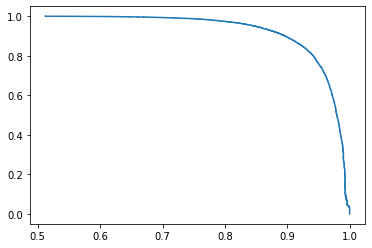

In [36]:
plt.plot(precision, recall)